In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
# Import data and keras layers
import numpy as np
from keras.datasets import mnist
from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, Dense, Reshape
from keras.layers import Flatten, Dropout, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
(x1_train, y1_train), (x1_test, y1_test) = mnist.load_data()

# Format data
x1_train = x1_train.astype('float32')
x1_test = x1_test.astype('float32') 

# Scaling to get the image in [-1, 1] range
x1_train = (x1_train - 127.5) / 127.5
x1_test = (x1_test - 127.5) / 127.5

x1_train = np.reshape(x1_train, (len(x1_train), 28, 28, 1))
x1_test = np.reshape(x1_test, (len(x1_test), 28, 28, 1))

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Creating the generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100))
generator.add(Activation('relu'))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D((2,2)))
generator.add(Conv2D(64, kernel_size = (5, 5), padding = 'same'))
generator.add(Activation('relu'))
generator.add(BatchNormalization())
generator.add(UpSampling2D((2,2)))
generator.add(Conv2D(1, kernel_size = (5, 5), padding = 'same'))
generator.add(Activation('tanh'))
print(generator.summary())
generator.compile(loss = 'binary_crossentropy', optimizer = adam)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
__________

In [0]:
# Creating the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))
print(discriminator.summary())
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total para

In [0]:
# Create the GAN
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

In [0]:
# Visualize generated data
def plotGeneratedImages():
  generated_images = generator.predict(noise)
  fig = plt.figure(figsize=(9, 9))        
  for i in range(9):
    plt.subplot(3, 3, i+1)
    img = generated_images[i, :] * 0.5 + 0.5
    img = img.reshape((28, 28))
    plt.tight_layout()
    plt.imshow(img, cmap='gray')
    plt.axis('off')

100%|██████████| 1875/1875 [01:09<00:00, 27.77it/s]


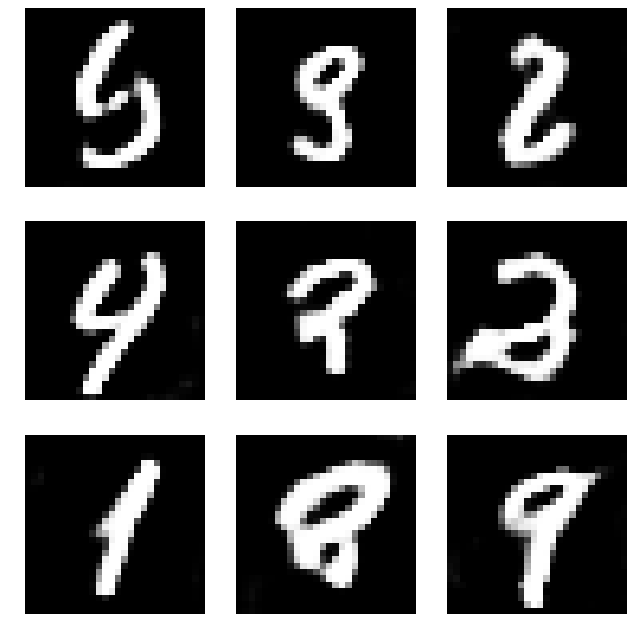

In [0]:
epochs = 10
batch_size = 32

batch_count = int(x1_train.shape[0] / batch_size)

for epoch in range(epochs):

    for index in tqdm(range(batch_count)):
        
        # Real images
        image_batch = x1_train[index * batch_size: (index + 1) * batch_size]
        
        # Get initial random input for generator
        noise = np.random.uniform(-1, 1, size=[batch_size, 100])
        # Generating images
        generated_data = generator.predict_on_batch(noise)

        X = np.concatenate([generated_data, image_batch])
        y = np.zeros(2 * batch_size)
        y[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x=X, y=y)

        # Train generator 
        y = np.zeros(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(x=noise, y=y)
        
        img = generated_images = generator.predict(noise)   

plotGeneratedImages()


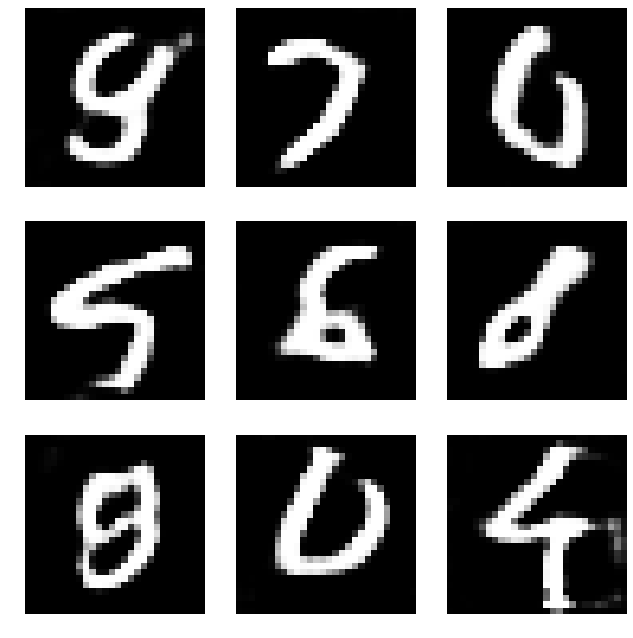

In [0]:
noise = np.random.uniform(-1, 1, size=[batch_size, 100])
plotGeneratedImages()